In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import skfuzzy as fuzz
from sklearn.cluster import KMeans
from L63_noisy import intL63_noisy, intL63_noisy_fix
from mpl_toolkits.mplot3d import Axes3D
# from sklearn.metrics import silhouette_score


# fix the random seed
np.random.seed(2022)

# set experiment parameters
dt = 0.005  # model integration time step, dtda should be divisible to dt
N = 20000  # integration time steps

# set L63 model parameters
par = (10, 28, 8 / 3)  # sigma, rho, beta
sigma = (5, 5, 5)

# create the nature run
# # X0 = np.random.normal(0, 1, (3, 1))
# # truth = intL63_noisy(X0, par[0], par[1], par[2], sigma[0], sigma[1], sigma[2], dt, N, 1)
truth = np.load('nature_run1.npy')


x Decorrelation Time: 0.21 time units
y Decorrelation Time: 0.16 time units
z Decorrelation Time: 43.40 time units


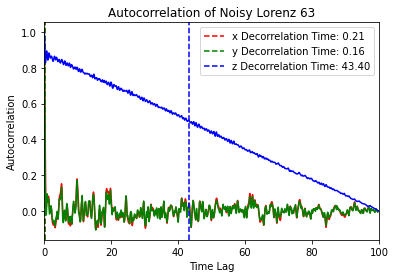

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate autocorrelation function
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)  # Normalize
    return result[result.size // 2:]

autocorr_x = autocorr(truth[0,0,:])  # Autocorrelation of x component
autocorr_y = autocorr(truth[1,0,:])  # Autocorrelation of y component
autocorr_z = autocorr(truth[2,0,:])  # Autocorrelation of z component

# Find decorrelation time (time lag at which autocorrelation drops to a certain threshold)
threshold = 0.5
decorrelation_time_index = np.argmax(autocorr_x < threshold)
decorrelation_time_x = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_y < threshold)
decorrelation_time_y = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_z < threshold)
decorrelation_time_z = decorrelation_time_index * dt

tmax = dt*autocorr_x.shape[0]
t = np.arange(0.0, tmax, dt)
# Plot autocorrelation function and decorrelation time
plt.plot(t, autocorr_x, color='r')
plt.axvline(x=decorrelation_time_x, color='r', linestyle='--', label=f'x Decorrelation Time: {decorrelation_time_x:.2f}')
plt.plot(t, autocorr_y, color='g')
plt.axvline(x=decorrelation_time_y, color='g', linestyle='--', label=f'y Decorrelation Time: {decorrelation_time_y:.2f}')
plt.plot(t, autocorr_z, color='b')
plt.axvline(x=decorrelation_time_z, color='b', linestyle='--', label=f'z Decorrelation Time: {decorrelation_time_z:.2f}')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Noisy Lorenz 63')
plt.legend()
plt.xlim(0, tmax)
# plt.show()
plt.savefig('../../fig/autocorr_L63.png', dpi=150)

print(f"x Decorrelation Time: {decorrelation_time_x:.2f} time units")
print(f"y Decorrelation Time: {decorrelation_time_y:.2f} time units")
print(f"z Decorrelation Time: {decorrelation_time_z:.2f} time units")



Fold 1
epoch0
Fold [1/5], Epoch [1/5], Avg. Training Loss: 0.0816
epoch1
Fold [1/5], Epoch [2/5], Avg. Training Loss: 0.0572
epoch2
Fold [1/5], Epoch [3/5], Avg. Training Loss: 0.0484
epoch3
Fold [1/5], Epoch [4/5], Avg. Training Loss: 0.0437
epoch4
Fold [1/5], Epoch [5/5], Avg. Training Loss: 0.0409
Fold 2
epoch0
Fold [2/5], Epoch [1/5], Avg. Training Loss: 0.0736
epoch1
Fold [2/5], Epoch [2/5], Avg. Training Loss: 0.0532
epoch2
Fold [2/5], Epoch [3/5], Avg. Training Loss: 0.0455
epoch3
Fold [2/5], Epoch [4/5], Avg. Training Loss: 0.0412
epoch4
Fold [2/5], Epoch [5/5], Avg. Training Loss: 0.0387
Fold 3
epoch0
Fold [3/5], Epoch [1/5], Avg. Training Loss: 0.0657
epoch1
Fold [3/5], Epoch [2/5], Avg. Training Loss: 0.0498
epoch2
Fold [3/5], Epoch [3/5], Avg. Training Loss: 0.0439
epoch3
Fold [3/5], Epoch [4/5], Avg. Training Loss: 0.0407
epoch4
Fold [3/5], Epoch [5/5], Avg. Training Loss: 0.0387
Fold 4
epoch0
Fold [4/5], Epoch [1/5], Avg. Training Loss: 0.0657
epoch1
Fold [4/5], Epoch [2/

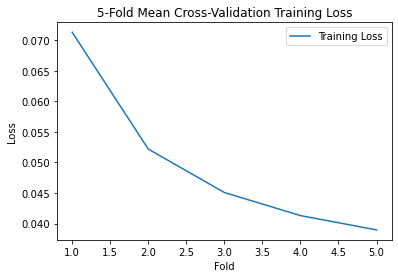

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


torch.manual_seed(1)

# Hyperparameters
batch_size = 32
num_classes = 2
hidden_size = 64
sequence_length = 40  # length of time sequences
input_size = 6  # num_features
learning_rate = 0.001
num_epochs = 5

# load labeled time series data
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)
labels = np.load('FuzKmeans_label_2center.npy')[sequence_length:]

# create sequence data
X_new = np.zeros((X.shape[0]-sequence_length, sequence_length,X.shape[1],))
for i in range(X.shape[0]-sequence_length):
    X_new[i,:,:] = X[i:i+sequence_length,:]

# Define a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Initialize the dataset and data loader
dataset = TimeSeriesDataset(X_new, labels)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True)
accuracies_train = []
accuracies_val = []
fold_training_losses = np.zeros((5, num_epochs))

# Perform 5-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}")
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = LSTMClassifier(input_size, hidden_size, num_classes).double()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_losses = []
    avg_training_losses = []

    # Train the model
    for epoch in range(num_epochs):
        print('epoch{:d}'.format(epoch))
        
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(torch.double)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.item())
        avg_training_loss = np.mean(training_losses)
        print(f"Fold [{fold + 1}/{kf.get_n_splits()}], Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_training_loss:.4f}")
        avg_training_losses.append(avg_training_loss)
    
    fold_training_losses[fold, :] = np.array(avg_training_losses)
    
    # Evaluate on validation data
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    accuracy_val = total_correct / total_samples
    accuracies_val.append(accuracy_val)

print('mean validation accuracy of 5 folds:{:.4f}'.format(np.mean(accuracies_val)))

# Plot the average loss for training
plt.plot(range(1, 6), np.mean(fold_training_losses,axis=0), label='Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('5-Fold Mean Cross-Validation Training Loss')
plt.legend()
plt.show()

# To make predictions using the trained model:
# testData = torch.randn(batch_size, sequence_length, input_size)
# predicted_labels = torch.argmax(model(testData), dim=1)


In [15]:
# train with full dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

np.random.seed(2022)
torch.manual_seed(1)

# Hyperparameters
batch_size = 32
num_classes = 2
hidden_size = 64
sequence_length = 40  # length of time sequences
input_size = 6  # num_features
learning_rate = 0.001
num_epochs = 5

# load labeled time series data
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)
labels = np.load('FuzKmeans_label_2center.npy')[sequence_length:]

# create sequence data
X_new = np.zeros((X.shape[0]-sequence_length, sequence_length,X.shape[1],))
for i in range(X.shape[0]-sequence_length):
    X_new[i,:,:] = X[i:i+sequence_length,:]

# Define a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Define LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the dataset and data loader
dataset = TimeSeriesDataset(X_new, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LSTMClassifier(input_size, hidden_size, num_classes).double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = []
avg_training_losses = []

# Train the model
for epoch in range(num_epochs):
    print('epoch{:d}'.format(epoch))

    model.train()
    for inputs, labels in dataloader:
        inputs = inputs.to(torch.double)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    avg_training_loss = np.mean(training_losses)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}")
    avg_training_losses.append(avg_training_loss)

# fold_training_losses[fold, :] = np.array(avg_training_losses)

# # Evaluate on validation data
# model.eval()
# total_correct = 0
# total_samples = 0
# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total_correct += (predicted == labels).sum().item()
#         total_samples += labels.size(0)
# accuracy_val = total_correct / total_samples
# accuracies_val.append(accuracy_val)

# print('validation accuracy:{:.4f}'.format(accuracy_val))

epoch0
Epoch [1/5], Training Loss: 0.0724
epoch1
Epoch [2/5], Training Loss: 0.0525
epoch2
Epoch [3/5], Training Loss: 0.0453
epoch3
Epoch [4/5], Training Loss: 0.0416
epoch4
Epoch [5/5], Training Loss: 0.0392


Accuracy lstm: 0.9837683482791443
Precision lstm: 0.9842364294711619
Recall lstm: 0.9837738276401107


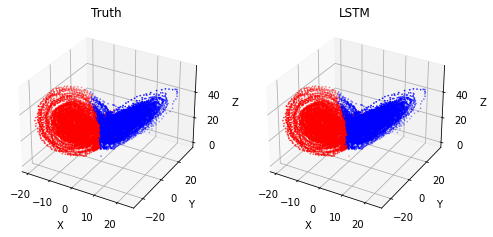

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

# ------------------------------------------------------------
# scatter truth and predict on test data
# use Fuzzy C-means clusetered results as truth
truth_label = np.load('FuzKmeans_label_2center_test.npy')[sequence_length:]
sol = np.squeeze(np.load('sol_test.npy'))
der = np.squeeze(np.load('der_test.npy'))
X = np.concatenate([sol, der], axis=0).T
# create sequence data
X_new = np.zeros((X.shape[0]-sequence_length, sequence_length,X.shape[1],))
for i in range(X.shape[0]-sequence_length):
    X_new[i,:,:] = X[i:i+sequence_length,:]
test_data = X_new

# predict
outputs = model(torch.from_numpy(test_data))
_, lstm_label = torch.max(outputs, 1)

# reverse label 0 - 1
lstm_label = - lstm_label + 1
accuracy_lstm, precision_lstm, recall_lstm = evaluate_predictions(truth_label, lstm_label)
# roc_auc_score_lstm = roc_auc_score(truth_label, 1 - lstm_classifier.predict_proba(test_data)[:, 1], average='macro')

print("Accuracy lstm:", accuracy_lstm)
print("Precision lstm:", precision_lstm)
print("Recall lstm:", recall_lstm)
# print("ROC_AUC lstm:", roc_auc_score_lstm)


fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(projection='3d'))
colors = ['b', 'r', 'g', 'orange']
ncenters = 2
x_data = sol[0, sequence_length:]
y_data = sol[1, sequence_length:]
z_data = sol[2, sequence_length:]

for j in range(ncenters):
    axes1[0].scatter(x_data[truth_label == j], y_data[truth_label == j], z_data[truth_label == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
axes1[0].set_xlabel('X')
axes1[0].set_ylabel('Y')
axes1[0].set_zlabel('Z')
axes1[0].set_title('Truth')

for j in range(ncenters):
    axes1[1].scatter(x_data[lstm_label == j], y_data[lstm_label == j], z_data[lstm_label == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
axes1[1].set_xlabel('X')
axes1[1].set_ylabel('Y')
axes1[1].set_zlabel('Z')
axes1[1].set_title('LSTM')

# for j in range(ncenters):
#     axes1[2].scatter(x_data[flstm_label == j], y_data[flstm_label == j], z_data[flstm_label == j],
#                label=f'Regime {j+1}', s=.5, color=colors[j])
# axes1[2].set_xlabel('X')
# axes1[2].set_ylabel('Y')
# axes1[2].set_zlabel('Z')
# axes1[2].set_title('Fuzzy lstm')

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('LSTM_predict.png', dpi=150)
plt.show()

In [8]:
outputs = model(torch.from_numpy(test_data))


In [11]:
outputs[22,:]

tensor([-5.7715,  5.3467], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [26]:
import numpy as np
from scipy.optimize import minimize

# Simulated noisy Lorenz 63 time series data (replace this with your actual data)
time_series_data = np.squeeze(np.load('nature_run1.npy')).T

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(time_series_data)

# Surrogate model function
def surrogate_model(params, data, dt):
    x, y, z = data.T
    l = params[:9].reshape(3, 3)
    b = params[9:18].reshape(3, 3)
    sigma = params[18:21]
    
    dx = (l[0, 0] * x + l[0, 1] * y + l[0, 2] * z + b[0, 0] * x**2 + b[0, 1] * x * y + b[0, 2] * x * z)*dt
    dy = (l[1, 0] * x + l[1, 1] * y + l[1, 2] * z + b[1, 0] * x**2 + b[1, 1] * x * y + b[1, 2] * x * z)*dt
    dz = (l[2, 0] * x + l[2, 1] * y + l[2, 2] * z + b[2, 0] * x**2 + b[2, 1] * x * y + b[2, 2] * x * z)*dt
    
    noisy_dx = dx + sigma[0] * np.random.normal(size=len(dx)) * np.sqrt(dt)
    noisy_dy = dy + sigma[1] * np.random.normal(size=len(dy)) * np.sqrt(dt)
    noisy_dz = dz + sigma[2] * np.random.normal(size=len(dz)) * np.sqrt(dt)
    
    return np.column_stack((noisy_dx, noisy_dy, noisy_dz))

# Negative log-likelihood function for EM optimization
def neg_log_likelihood(params, data, dt):
    surrogate_states = surrogate_model(params, data[:-1], dt)
    residuals = surrogate_states - data[1:]
    likelihood = -0.5 * np.sum(residuals**2) / (3 * np.sum(sigma**2 * dt))
    return -likelihood

# Initialize parameters
initial_params = np.random.rand(21)  # Change the initialization based on your needs

# Optimization using EM algorithm
result = minimize(neg_log_likelihood, initial_params, args=(time_series_data, dt), method='L-BFGS-B')

# Extract learned parameters
learned_params = result.x

print("Learned Parameters:", learned_params)


TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'int'

In [24]:
time_series_data.shape

(20001, 3)

In [27]:
dt

0.005